In [80]:
import tensorflow
import os
import pydot
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from tensorflow import random
import cv2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Input
from tensorflow.keras.models import Model 
from sklearn.model_selection import train_test_split
from pathlib import PurePosixPath as PPP 

In [81]:
train_dir = "../input/fer2013/train/" 
test_dir = "../input/fer2013/test/"

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


In [82]:
img_size = 48
# data augmentation by flipping the image
train_datagen = ImageDataGenerator(horizontal_flip= True, 
                                    rescale= 1./255,
                                    zoom_range = 0.3)

validation_datagen = ImageDataGenerator(rescale=1./255) 

In [83]:
train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    target_size = (img_size, img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(directory = test_dir, 
                                                    target_size = (img_size, img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [53]:
input_shape = (48, 48, 1)
# architecture making 

def create_basic_model(input_shape):

    inputs = Input(shape=input_shape)   #input layer 
    model = tensorflow.keras.models.Sequential()

    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape)(inputs)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=(3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.01))(x)
    x = Conv2D(256, kernel_size=(3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(7, activation = 'softmax')(x)

    model = Model(inputs=inputs, outputs = output)

    model.summary()

    return model

model = create_basic_model(input_shape)

2022-10-21 05:46:29.998984: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856 

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor= 'val_loss', mode='min', verbose=1, patience=5)

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

#Defining te callback functions. 

LETS NOW TRAIN THE MODEL

In [8]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy', 
                optimizer = optimizers.Adam(learning_rate=0.0001, decay = 1e-6), 
                metrics = ['accuracy'])

history = model.fit(x = train_generator, epochs = 80, validation_data = validation_generator, 
                    callbacks = [es, mc])

2022-10-20 12:36:32.399290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80
449/449 [==============================] - 666s 1s/step - loss: 4.2717 - accuracy: 0.2752 - val_loss: 7.0106 - val_accuracy: 0.1853

Epoch 00001: val_loss improved from inf to 7.01061, saving model to best_model.h5
Epoch 2/80
449/449 [==============================] - 583s 1s/step - loss: 3.4243 - accuracy: 0.3306 - val_loss: 3.0201 - val_accuracy: 0.3947

Epoch 00002: val_loss improved from 7.01061 to 3.02009, saving model to best_model.h5
Epoch 3/80
449/449 [==============================] - 591s 1s/step - loss: 2.8652 - accuracy: 0.3661 - val_loss: 2.5446 - val_accuracy: 0.4156

Epoch 00003: val_loss improved from 3.02009 to 2.54457, saving model to best_model.h5
Epoch 4/80
449/449 [==============================] - 583s 1s/step - loss: 2.4487 - accuracy: 0.3966 - val_loss: 2.1750 - val_accuracy: 0.4466

Epoch 00004: val_loss improved from 2.54457 to 2.17503, saving model to best_model.h5
Epoch 5/80
449/449 [==============================] - 586s 1s/step - loss: 2.1396 - 

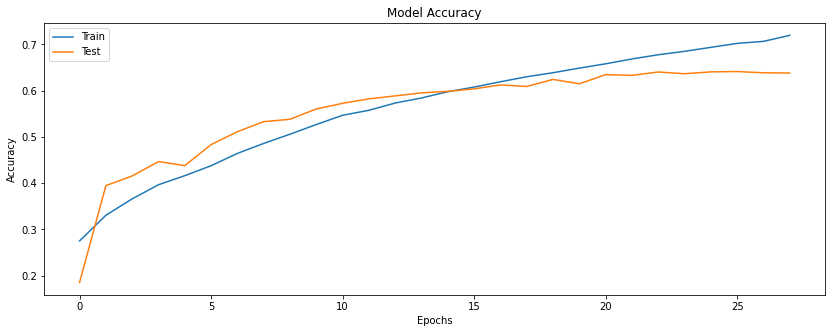

In [10]:
plt.figure(figsize=(14,5))
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

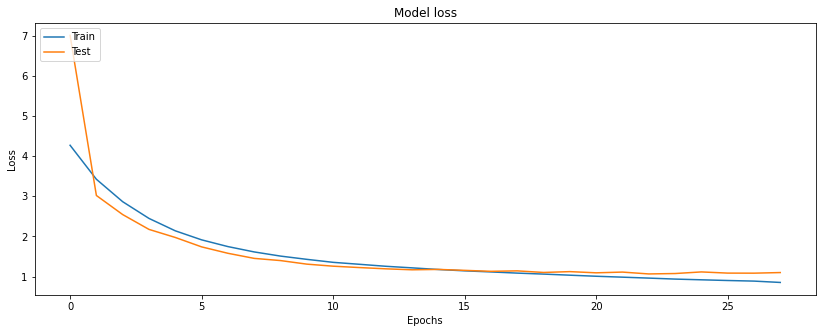

In [11]:
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()


In [14]:
model.save_weights('model.h')

In [20]:
import cv2
import numpy as np
face_classifier = cv2.CascadeClassifier('/haarcascade_frontalface_default.xml')

In [51]:
def prediction(image):
    img = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    print('original dimensions: ', img.shape)
    
    scale_percent = 40
    width = int(img.shape[1]*scale_percent/100)
    height = int(img.shape[0]*scale_percent/100)
    dim = (width,height)
    
    #resized image
    resized = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
    
    print('Resized Dimension: ',resized.shape)
    
#     cv2.imshow("Resized image",resized)
#     cv2.waitkey(0)
#     cv2.destroyAllWindow()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.0485258, 6)
    if faces is ():
        print("No faces found")
    for (x,y,w,h) in faces:
        cv2.rectangle(resized, (x,y), (x+w,y+h), (127,0,255), 2)
    
        cropped_image = resized[y:y+h, x:x+w]
        print([x,y,w,h])
        plt.imshow(cropped_image)
        cv2.imwrite('contour1.png', cropped_image)
    
    
    
        

original dimensions:  (339, 509, 3)
Resized Dimension:  (135, 203, 3)
[105, 42, 27, 27]
[134, 19, 31, 31]
[75, 70, 29, 29]
[146, 81, 29, 29]
[115, 87, 29, 29]


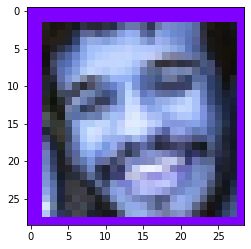

In [52]:
prediction("../input/happyhappy/behappy.jpeg")

In [70]:
from PIL import Image
im = Image.open("./contour1.png")
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
print(width,height)
 
# # Setting the points for cropped image
# left = 4
# top = height / 5
# right = 154
# bottom = 3 * height / 5
 
# # Cropped image of above dimension
# # (It will not change original image)
# im1 = im.crop((left, top, right, bottom))
newsize = (48,48)
im1 = im.resize(newsize)
print(im1.size)
# print(im1.shape())
# Shows the image in image viewer
im1.show()

29 29
(48, 48)


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpfptibko8.PNG'


(48, 48, 3)
(48, 48, 1)


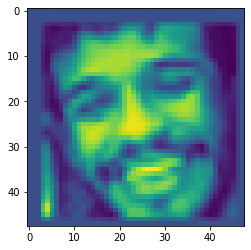

In [88]:
im11 = np.array(im1)
print(im11.shape)
im12=cv2.cvtColor(im11,cv2.COLOR_BGR2GRAY).reshape((48,48,1))
print(im12.shape)
plt.imshow(im12)


In [89]:
im13 = train_datagen.flow_from_directory(directory = im1, 
                                                    target_size = (img_size, img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical")
y_pred = model.predict(im13)

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not Image

In [ ]:
# cv2.ocl.setUseOpenCL(False)
# emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
# cap = cv2.VideoCapture(0)
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     bounding_box = cv2.CascadeClassifier('/home/shivam/.local/lib/python3.6/site-packages/cv2/data/haarcascade_frontalface_default.xml')
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2gray_frame)
#     num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)
#     for (x, y, w, h) in num_faces:
#         cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
#         roi_gray_frame = gray_frame[y:y + h, x:x + w]
#         cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
#         emotion_prediction = emotion_model.predict(cropped_img)
#         maxindex = int(np.argmax(emotion_prediction))
#         cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#     cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
#     if cv2.waitKey(1) & 0xFF == ord('q'):
# cap.release()
# cv2.destroyAllWindows()
#     break